In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from tqdm import tqdm
sns.set(style="darkgrid")
nltk.download('punkt')
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from tslearn.clustering import KShape
plt.style.use('seaborn-whitegrid')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\march\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\march\anaconda3\envs\ada\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
C:\Users\march\AppData\Local\Temp\ipykernel_2444\3099230263.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Normalizing and dropping neutral, then scaling each emotion

In [3]:
df_emotions = pd.read_pickle("../../data/emotions_interpolated_20.pkl")
df_emotions_raw = pd.read_pickle("../../data/emotions_data_raw.pkl")
df_metadata = pd.read_pickle("../../data/final_dataset.pkl")
emotion_columns = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]
df_emotions

,anger,disgust,fear,joy,neutral,sadness,surprise,Wikipedia_movie_ID,timestep
0,0.008854,0.029581,0.002972,0.115284,0.753907,0.025629,0.063773,3333,0
1,0.020809,0.070973,0.033560,0.082080,0.771024,0.012630,0.008924,3333,1
2,0.016042,0.078240,0.065199,0.005752,0.066704,0.763973,0.004088,3333,2
3,0.007964,0.042619,0.052491,0.003172,0.091407,0.785047,0.017299,3333,3
4,0.080363,0.090461,0.030861,0.007990,0.272579,0.512997,0.004750,3333,4
...,...,...,...,...,...,...,...,...,...
686835,0.015265,0.148570,0.114552,0.009460,0.555081,0.134403,0.022669,37373877,15
686836,0.014070,0.187139,0.126397,0.011102,0.487088,0.170217,0.003987,37373877,16
686837,0.011060,0.132366,0.085783,0.008578,0.638195,0.118761,0.005258,37373877,17
686838,0.008050,0.077592,0.045170,0.006053,0.789302,0.067304,0.006528,37373877,18


Getting rid of movies with too small amount of sentences since K-shape needs same size time series

In [4]:
df_emotions_raw['sentence_id'] = (df_emotions_raw.groupby('Wikipedia_movie_ID').cumcount() + 1)
sentence_counts = df_emotions_raw.groupby('Wikipedia_movie_ID').size()
valid_movies = sentence_counts[(sentence_counts >= 10) & (sentence_counts <= 80)].index
print(len(valid_movies))
df_emotions = df_emotions[df_emotions['Wikipedia_movie_ID'].isin(valid_movies)]
df_emotions.reset_index(drop=True, inplace=True)

24474


Grouping by emotions

In [5]:
anger_df = df_emotions[["anger", "Wikipedia_movie_ID", "timestep"]]
anger_df = anger_df.pivot(index='Wikipedia_movie_ID', columns='timestep', values='anger')
X_anger = anger_df.values
X_anger = TimeSeriesScalerMinMax().fit_transform(X_anger)

joy_df = df_emotions[["joy", "Wikipedia_movie_ID", "timestep"]]
joy_df = joy_df.pivot(index='Wikipedia_movie_ID', columns='timestep', values='joy')
X_joy = joy_df.values
X_joy = TimeSeriesScalerMinMax().fit_transform(X_joy)


disgust_df = df_emotions[["disgust", "Wikipedia_movie_ID", "timestep"]]
disgust_df = disgust_df.pivot(index='Wikipedia_movie_ID', columns='timestep', values='disgust')
X_disgust = disgust_df.values
X_disgust = TimeSeriesScalerMinMax().fit_transform(X_disgust)

fear_df = df_emotions[["fear", "Wikipedia_movie_ID", "timestep"]]
fear_df = fear_df.pivot(index='Wikipedia_movie_ID', columns='timestep', values='fear')
X_fear = fear_df.values
X_fear = TimeSeriesScalerMinMax().fit_transform(X_fear)

neutral_df = df_emotions[["neutral", "Wikipedia_movie_ID", "timestep"]]
neutral_df = neutral_df.pivot(index='Wikipedia_movie_ID', columns='timestep', values='neutral')
X_neutral = neutral_df.values
X_neutral = TimeSeriesScalerMinMax().fit_transform(X_neutral)

sadness_df = df_emotions[["sadness", "Wikipedia_movie_ID", "timestep"]]
sadness_df = sadness_df.pivot(index='Wikipedia_movie_ID', columns='timestep', values='sadness')
X_sadness = sadness_df.values
X_sadness = TimeSeriesScalerMinMax().fit_transform(X_sadness)

surprise_df = df_emotions[["surprise", "Wikipedia_movie_ID", "timestep"]]
surprise_df = surprise_df.pivot(index='Wikipedia_movie_ID', columns='timestep', values='surprise')
X_surprise = surprise_df.values
X_surprise = TimeSeriesScalerMinMax().fit_transform(X_surprise)

In [6]:
df_genres = df_metadata[['Wikipedia_movie_ID', 'category']]
df_genres = df_genres[df_genres['Wikipedia_movie_ID'].isin(valid_movies)]
emotions_data = {"anger": X_anger, "joy": X_joy, "disgust": X_disgust, "fear": X_fear, "neutral": X_neutral, "sadness": X_sadness, "surprise": X_surprise}

In [7]:
cluster_assignment = pd.read_pickle("../../data/emotions_cluster_assignments.pkl")
cluster_assignment
y_joy = cluster_assignment['joy']
y_anger = cluster_assignment['anger']
y_disgust = cluster_assignment['disgust']
y_fear = cluster_assignment['fear']
y_neutral = cluster_assignment['neutral']
y_sadness = cluster_assignment['sadness']
y_surprise = cluster_assignment['surprise']


# Utils functions

In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#utils hex to rgba
def hex_to_rgba(hex_color, alpha=0.2):
    hex_color = hex_color.lstrip('#') 
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4)) 
    return f"rgba({r}, {g}, {b}, {alpha})"

#function to plot the elbow for k-shape clustering
def plot_elbow_kshape(X, subsample, emotion_title):
    subsample_size = min(subsample, len(X))
    X_subsample = resample(X, n_samples=subsample_size, random_state=0)

    inertias = []
    for k in range(2, 10): 
        kshape_model = KShape(n_clusters=k, verbose=False, random_state=0)
        kshape_model.fit(X_subsample)
        inertias.append(kshape_model.inertia_)

   #plot
    plt.figure(figsize=(8, 5))
    plt.plot(range(2, 10), inertias, 'o-', markerfacecolor='red')
    plt.title(f"Elbow Method for {emotion_title}")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia (Sum of Squared Distances)")
    plt.grid(True, linestyle=":")
    plt.show()

#function to one shot all k-shape elbow plots
def plot_elbow_for_all_emotions(emotion_data, subsample):
    for emotion, X in tqdm(emotion_data.items(), desc="Processing all emotions", unit="emotion"):
        plot_elbow_kshape(X, subsample, emotion_title=emotion)


#function to run the k-shape clustering pipeline
def clustering_k_shape_pipeline(emotion_to_cluster, n_cluster, recalculate_clusters=False):

    # load the data needed
    df_emotions = pd.read_pickle("../../data/emotions_interpolated_20.pkl")
    df_emotions_raw = pd.read_pickle("../../data/emotions_data_raw.pkl")
    df_metadata = pd.read_pickle("../../data/final_dataset.pkl")    
    
    # let's get rid of movies that are too short or too long, firstly to reduce the computational cost
    # and secondly because they are less interesting (extrapolated or squished data)
    df_emotions_raw['sentence_id'] = (df_emotions_raw.groupby('Wikipedia_movie_ID').cumcount() + 1)
    sentence_counts = df_emotions_raw.groupby('Wikipedia_movie_ID').size()
    valid_movies = sentence_counts[(sentence_counts >= 10) & (sentence_counts <= 80)].index
    df_emotions = df_emotions[df_emotions['Wikipedia_movie_ID'].isin(valid_movies)]
    df_emotions.reset_index(drop=True, inplace=True)

    # normalize the data
    emotion_df = df_emotions[[emotion_to_cluster, "Wikipedia_movie_ID", "timestep"]]
    emotion_df = emotion_df.pivot(index='Wikipedia_movie_ID', columns='timestep', values=emotion_to_cluster)
    X = emotion_df.values
    X = TimeSeriesScalerMinMax().fit_transform(X)

    #join with the genre data
    df_genres = df_metadata[['Wikipedia_movie_ID', 'category']]
    df_genres = df_genres[df_genres['Wikipedia_movie_ID'].isin(valid_movies)]


    #to avoid recalculating the clusters, we will load the cluster assignments
    if recalculate_clusters:
        model = KShape(n_clusters=4, verbose=True, random_state=0)
        y = model.fit(X).predict(X)
        y_df = pd.DataFrame({'Wikipedia_movie_ID': df_genres["Wikipedia_movie_ID"], 'cluster_label': y_joy})

    else:
        cluster_assignment = pd.read_pickle("../../data/emotions_cluster_assignments.pkl")
        y = cluster_assignment[emotion_to_cluster]
    return X, y


#function to plot the cluster evolution for each cluster in an emotion
def plot_cluster_evolution_plotly(X, y, nb_clusters, title, emotion, save=False):
    
    fig = make_subplots(
        rows=1, cols=nb_clusters,
        subplot_titles=[f"Cluster {i}" for i in range(nb_clusters)]
    )

    time_steps = np.arange(20)
    colors = ["#ff6666", "#b266ff", "#ffb266", "#66ff66", "#a9a9a9", "#66b2ff", "#ffff66"]
    
    #iterate over clusters
    for cluster_id in range(nb_clusters):

        # extract movies in the cluster
        cluster_indices = np.where(y == cluster_id)[0]
        cluster_data = X[cluster_indices]

        #calculate std and mean
        avg_evolution = np.mean(cluster_data, axis=0).reshape(-1)
        std_deviation = np.std(cluster_data, axis=0).reshape(-1)

        #plot mean
        fill_color_rgba = hex_to_rgba(colors[cluster_id], alpha=0.2)
        fig.add_trace(
            go.Scatter(
                x=time_steps,
                y=avg_evolution,
                mode='lines',
                name=f'avg',
                line=dict(color=colors[cluster_id], width=3)
            ),
            row=1, col=cluster_id + 1
        )

        #plot std
        fig.add_trace(
            go.Scatter(
                x=np.concatenate([time_steps, time_steps[::-1]]),
                y=np.concatenate([
                    avg_evolution + std_deviation,
                    (avg_evolution - std_deviation)[::-1]
                ]),
                fill='toself',
                fillcolor=fill_color_rgba, 
                line=dict(color='rgba(255,255,255,0)'),
                name=f'std',
                hoverinfo='skip'
            ),
            row=1, col=cluster_id + 1
        )

    #uniform y axis
    for i in range(1, nb_clusters + 1):
        fig.update_yaxes(range=[0, 1], row=1, col=i)

    #global layout
    fig.update_layout(
        title=title,
        xaxis_title="Timesteps",
        plot_bgcolor='rgba(240,240,240,1)',
        showlegend=False, 
        width=2000, 
        height=500 
    )

    if save:
        fig.write_html(f"cluster_evolution_{emotion}.html")
    fig.show()


#function to plot the cluster sizes
def plot_cluster_sizes(cluster_sizes, nb_clusters, emotion, save=False):
    #bar chart
    fig = go.Figure(
        go.Bar(
            x=[f"Cluster {i}" for i in range(nb_clusters)],
            y=cluster_sizes,
            text=[f"{size}" for size in cluster_sizes],
            textposition='auto',
            marker=dict(color=["#ff6666", "#b266ff", "#ffb266", "#66ff66", "#a9a9a9", "#66b2ff", "#ffff66"][:nb_clusters]),
        )
    )
    fig.update_layout(
        title=f"Cluster sizes for the {emotion} emotion",
        xaxis_title="Clusters",
        yaxis_title="Size",
        plot_bgcolor="rgba(240, 240, 240, 1)",
        width=800,
        height=500
    )

    if save:
        fig.write_html(f"cluster_sizes_{emotion}.html")
    fig.show()


# Plot all elbows

Processing all emotions:   0%|          | 0/7 [00:00<?, ?emotion/s]

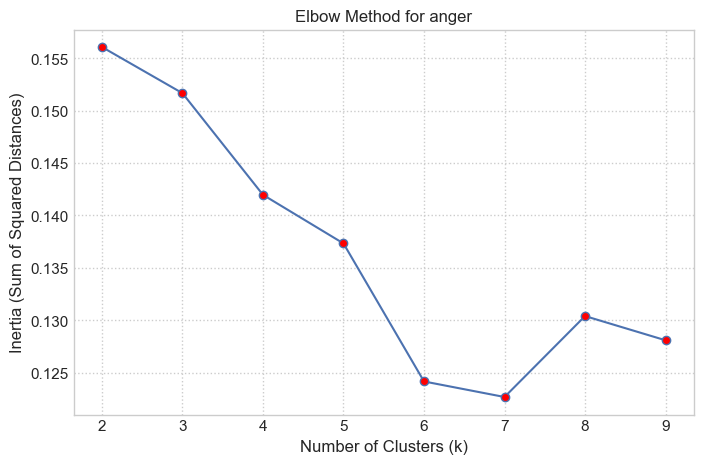

Processing all emotions:  14%|█▍        | 1/7 [23:36<2:21:40, 1416.78s/emotion]

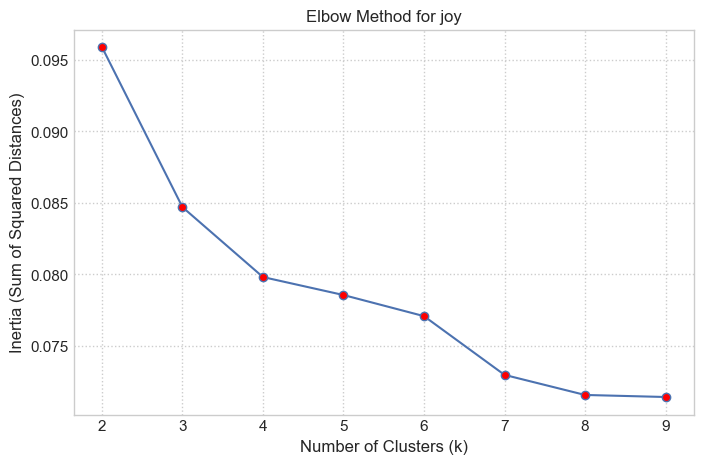

Processing all emotions:  29%|██▊       | 2/7 [42:06<1:43:01, 1236.32s/emotion]

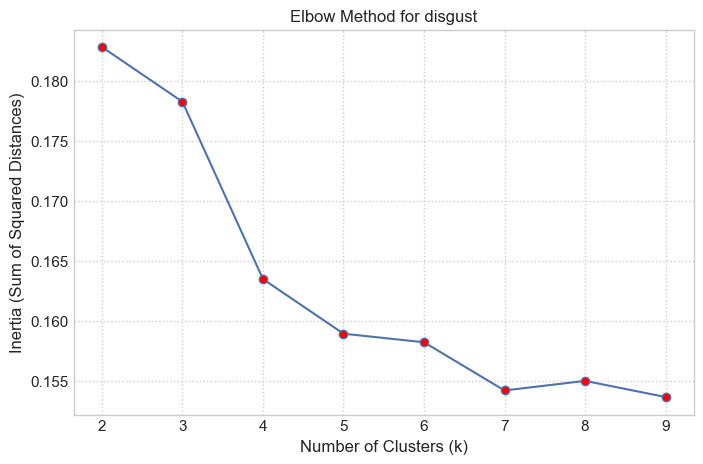

Processing all emotions:  43%|████▎     | 3/7 [1:10:32<1:36:42, 1450.52s/emotion]

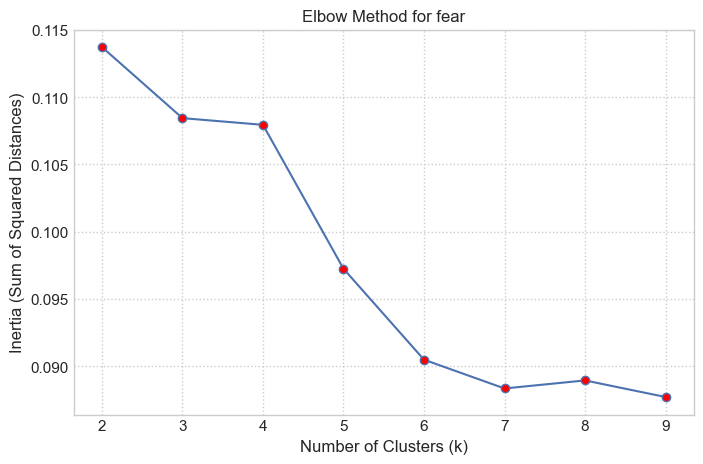

Processing all emotions:  57%|█████▋    | 4/7 [1:31:00<1:08:08, 1362.93s/emotion]

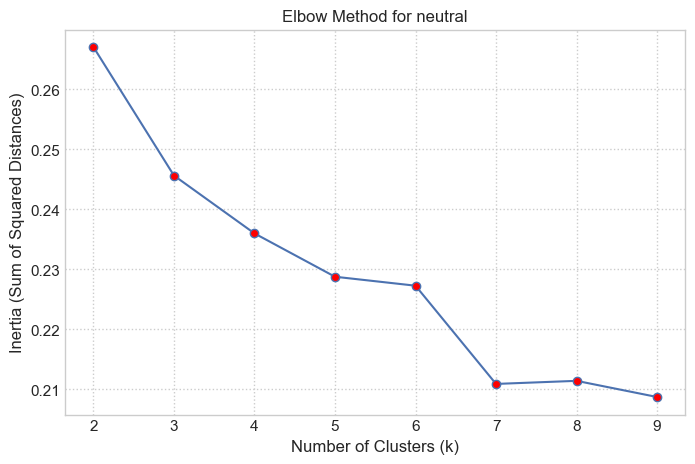

Processing all emotions:  71%|███████▏  | 5/7 [2:00:19<50:11, 1505.58s/emotion]  

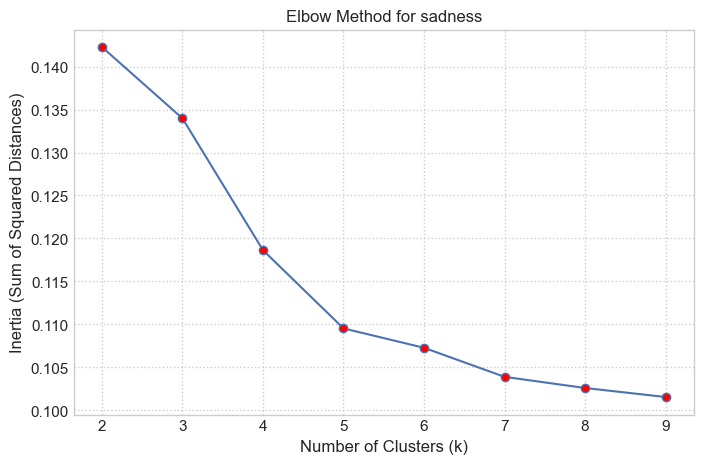

Processing all emotions:  86%|████████▌ | 6/7 [2:25:41<25:11, 1511.10s/emotion]

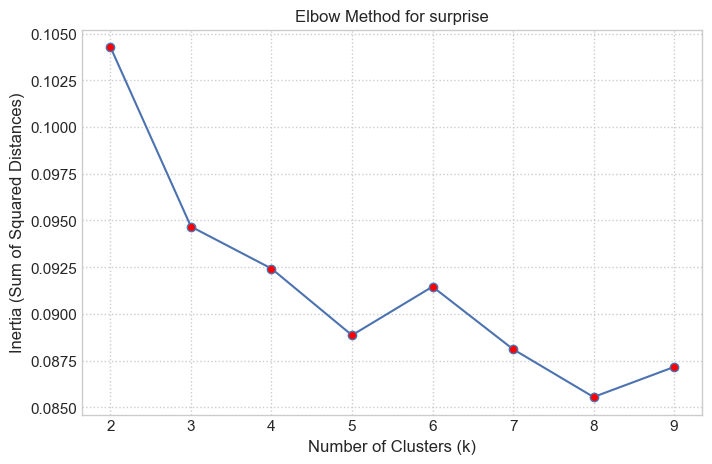

Processing all emotions: 100%|██████████| 7/7 [2:52:48<00:00, 1481.21s/emotion]


In [62]:
plot_elbow_for_all_emotions(emotions_data, 24474)

# Joy K-shape

In [66]:
model = KShape(n_clusters=4, verbose=True, random_state=0)
y_joy = model.fit(X_joy).predict(X_joy)
y_joy_df = pd.DataFrame({'Wikipedia_movie_ID': df_genres["Wikipedia_movie_ID"], 'cluster_label': y_joy})

0.088 --> 0.084 --> 0.085 --> 


In [10]:
plot_cluster_evolution_plotly(X_joy, y_joy, 4, "Shape clustering for the joy emotion", emotion="joy", save=True)
plot_cluster_sizes([np.sum(y_joy == i) for i in range(4)], 4, emotion="joy", save=True)


# Surprise K-shape

In [84]:
model = KShape(n_clusters=5, verbose=True, random_state=0)
y_surprise = model.fit(X_surprise).predict(X_surprise)
y_surprise_df = pd.DataFrame({'Wikipedia_movie_ID': df_genres["Wikipedia_movie_ID"], 'cluster_label': y_surprise})

0.094 --> 0.096 --> 


In [11]:
plot_cluster_evolution_plotly(X_surprise, y_surprise, 5, "Shape clustering for the surprise emotion", emotion="surprise", save=True)
plot_cluster_sizes([np.sum(y_surprise == i) for i in range(5)], 5, emotion="surprise", save=True)

# Anger K-shape

In [ ]:
model = KShape(n_clusters=6, verbose=True, random_state=0)
y_anger = model.fit(X_anger).predict(X_anger)
y_anger_df = pd.DataFrame({'Wikipedia_movie_ID': df_genres["Wikipedia_movie_ID"], 'cluster_label': y_anger})

0.159 --> 0.143 --> 0.135 --> 0.135 --> 0.133 --> 0.133 --> 0.130 --> 

In [169]:
plot_cluster_evolution_plotly(X_anger, y_anger, 6, "Shape clustering for the anger emotion", emotion="anger")
plot_cluster_sizes([np.sum(y_anger == i) for i in range(6)], 6, emotion="anger")

# Sadness K-shape

In [69]:
model = KShape(n_clusters=5, verbose=True, random_state=0)
y_sadness = model.fit(X_sadness).predict(X_sadness)
y_sadness_df = pd.DataFrame({'Wikipedia_movie_ID': df_genres["Wikipedia_movie_ID"], 'cluster_label': y_sadness})

0.135 --> 0.126 --> 0.122 --> 0.121 --> 0.120 --> 0.121 --> 


In [12]:
plot_cluster_evolution_plotly(X_sadness, y_sadness, 5, "Shape clustering for the sadness emotion", emotion="sadness", save=True)
plot_cluster_sizes([np.sum(y_sadness == i) for i in range(5)], 5, emotion="sadness", save=True)

# Disgust K-shape

In [71]:
model = KShape(n_clusters=5, verbose=True, random_state=0)
y_disgust = model.fit(X_disgust).predict(X_disgust)
y_disgust_df = pd.DataFrame({'Wikipedia_movie_ID': df_genres["Wikipedia_movie_ID"], 'cluster_label': y_disgust})

0.214 --> 0.188 --> 0.180 --> 0.199 --> 


In [171]:
plot_cluster_evolution_plotly(X_disgust, y_disgust, 5, "Shape clustering for the disgust emotion", emotion="disgust")
plot_cluster_sizes([np.sum(y_disgust == i) for i in range(5)], 5, emotion="disgust")

# Fear K-shape

In [75]:
model = KShape(n_clusters=7, verbose=True, random_state=0)
y_fear = model.fit(X_fear).predict(X_fear)
y_fear_df = pd.DataFrame({'Wikipedia_movie_ID': df_genres["Wikipedia_movie_ID"], 'cluster_label': y_fear})

0.105 --> 0.096 --> 0.094 --> 0.093 --> 0.112 --> 


In [ ]:
plot_cluster_evolution_plotly(X_fear, y_fear, 7, "Shape clustering for the fear emotion", emotion="fear", save=True)
plot_cluster_sizes([np.sum(y_fear == i) for i in range(7)], 7, emotion="fear", save=True)

# Storing for later use if needed

In [77]:
emotion_columns = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]
cluster_results = {
    "anger": y_anger,
    "disgust": y_disgust,
    "fear": y_fear,
    "joy": y_joy,
    "neutral": np.zeros(len(y_joy), dtype=int),
    "sadness": y_sadness,
    "surprise": y_surprise
}
df_cluster_assignments = pd.DataFrame(cluster_results)
df_cluster_assignments.index = df_genres["Wikipedia_movie_ID"]
df_cluster_assignments.head()

,anger,disgust,fear,joy,neutral,sadness,surprise
Wikipedia_movie_ID,,,,,,,
3333,1,0,1,0,0,1,1
3746,4,1,1,0,0,0,1
3837,4,0,1,0,0,0,4
3947,4,2,1,0,0,0,1
4227,3,1,3,0,0,0,1


# Retrieving interesting emotions arcs

In [156]:
#preparation of data for ines' analysis
def get_mean_emotion_arcs(X, y, emotion):
    unique_cluster_ids = np.unique(y)
    
    data = []
    for cluster_id in unique_cluster_ids:
        cluster_indices = np.where(y == cluster_id)[0]
        cluster_data = X[cluster_indices]
        mean_arc = np.mean(cluster_data, axis=0)
        
        data.append([emotion, cluster_id, mean_arc])
    
    df = pd.DataFrame(data, columns=['Emotion', 'cluster_id', 'mean_arc'])
    return df

def get_all_emotions_mean_arcs():
    emotion_data = {
    'anger': (X_anger, y_anger),
    'joy': (X_joy, y_joy),
    'disgust': (X_disgust, y_disgust),
    'fear': (X_fear, y_fear),
    'sadness': (X_sadness, y_sadness),
    'surprise': (X_surprise, y_surprise)
}
    #merging all into a df
    dfs = []

    for emotion, (X, y) in emotion_data.items():
        df = get_mean_emotion_arcs(X, y, emotion)
        dfs.append(df)
    result_df = pd.concat(dfs, ignore_index=True)
    file_path = "../../data/mean_emotion_arcs_k_shape_clusters.pkl"
    result_df.to_pickle(file_path)


In [155]:
get_all_emotions_mean_arcs()

In [165]:
X, y = clustering_k_shape_pipeline("joy", 4, recalculate_clusters=False)
plot_cluster_evolution_plotly(X, y, 4, "Shape clustering for the joy emotion", emotion="joy")
plot_cluster_sizes([np.sum(y == i) for i in range(4)], 4, emotion="joy")